## Setup

In [74]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import cosmology as csm
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.modeling.models import BlackBody
import math
from astropy.table import Table
from astropy.visualization import quantity_support
from specutils import Spectrum1D
from specutils import manipulation
import specutils
import statistics
import matplotlib as mpl
from wise_light_curves import *
from astropy.io import ascii


quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f2a4bb36f50>

In [75]:
# From Owen

def plot_prettier(dpi=300, fontsize=9, figsize = (11,8.5)):
    # import pyplot and set some parameters to make plots prettier
    import matplotlib.pyplot as plt
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    plt.rc('figure', figsize=figsize,facecolor='white')
    
    return
plot_prettier(600, fontsize=18)

### Popesso Main Sequence Lines

In [76]:
a0 = 0.20
a1 = -0.034
b0 = -26.134
b1 = 4.722
b2 = - 0.1925

def sfms(logm, t):
    return (a1*t + b1 )*logm + b2*logm**2 + (b0 + a0*t) # Popesso eqn 10

In [77]:
# Set redshift range

z_low = 0.4
z_high = 0.55

cosmo = csm.FlatLambdaCDM(H0 = 69.6, Om0 = 0.286)
age_high = cosmo.age(z_low)/(1*u.Gyr) # to appease the astropy units gods
age_low = cosmo.age(z_high)/(1*u.Gyr)
age_avg = (age_high + age_low)/2
print(age_high, age_low, age_avg)

9.403139584037506 8.282725159291557 8.842932371664531


In [78]:
# plotting ms lines

x = np.linspace(8.5, 12.5, num=200)
t = float(age_avg)

y = [] # line at average z
for i in range(len(x)):
    y.append(sfms(x[i], t))

# adding dashed lines at high and low redshift bounds
y1 = [] # z = low
y2 = [] # z = high
t1 = age_high
t2 = age_low
for i in range(len(x)):
    y1.append(sfms(x[i], t1))
    y2.append(sfms(x[i], t2))

### FITS File

In [79]:
def load_fits(fname):
    hdu = fits.open(fname)[1] #loads the fits file into python
    data = hdu.data      #accesses the data table
    return data

data = load_fits('eboss_dr17_summary_odtrim3_v3.fit')

In [80]:
# view columns in file:
data.columns

ColDefs(
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBER'; format = 'J'
    name = 'PMF_STRING'; format = '16A'
    name = 'Z'; format = 'D'
    name = 'Z_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'EBV_MW'; format = 'E'
    name = 'TARGET_TEXT'; format = '118A'
    name = 'TARGET_CODE'; format = '4A'
    name = 'NEV_3426_FLUX'; format = 'E'
    name = 'NEV_3426_FLUX_ERR'; format = 'E'
    name = 'NEV_3426_EW'; format = 'E'
    name = 'OII_3727_FLUX'; format = 'E'
    name = 'OII_3727_FLUX_ERR'; format = 'E'
    name = 'OII_3727_EW'; format = 'E'
    name = 'H_BETA_FLUX'; format = 'E'
    name = 'H_BETA_FLUX_ERR'; format = 'E'
    name = 'H_BETA_EW'; format = 'E'
    name = 'H_BETA_SIGMA'; format = 'E'
    name = 'H_BETA_SIGMA_ERR'; format = 'E'
    name = 'H_GAMMA_FLUX'; format = 'E'
    name = 'H_GAMMA_FLUX_ERR'; format = 'E'
    name = 'H_GAMMA_EW'; format = 'E'
    name = 'OIII_4363_FLUX'; format = 'E

In [81]:
# make cuts on S/N and your redshift bin

restrictions = np.where((data['LOGMSTAR'] > 8) & (data['Z'] > z_low) & (data['Z'] < z_high) & (data['LOGSFR_ERR'] < 0.3) & (data['LOGMSTAR_ERR'] < 0.2) & ((data['H_ALPHA_FLUX']/data['H_ALPHA_FLUX_ERR']) > 3) & ((data['H_BETA_FLUX']/data['H_BETA_FLUX_ERR']) > 5))[0]

In [82]:
data_clipped = np.array(data[restrictions])

In [83]:
sfr = data_clipped['LOGSFR']
mstar = data_clipped['LOGMSTAR']
redshift = data_clipped['Z']

ra = data_clipped['RA']
dec = data_clipped['DEC']
plate = data_clipped['PLATE']
mjd = data_clipped['MJD']
fiber = data_clipped['FIBER']

o3hb = data_clipped['LOGO3HB']
o3 = data_clipped['OIII_5007_FLUX']
hb = data_clipped['H_BETA_FLUX']
hb_err = data_clipped['H_BETA_FLUX_ERR']
ha = data_clipped['H_ALPHA_FLUX']
ha_err = data_clipped['H_ALPHA_FLUX_ERR']
hg = data_clipped['H_GAMMA_FLUX']
hg_err = data_clipped['H_GAMMA_FLUX_ERR']
n2 = data_clipped['NII_6584_FLUX']
n2_err = data_clipped['NII_6584_FLUX_ERR']
n2ha = data_clipped['LOGN2HA']

av_ism = data_clipped['AV_ISM']
av_ism_err = data_clipped['AV_ISM_ERR']
infiber = data_clipped['INFIBER']

c_bayes = data_clipped['CIGALE_GRIZW1W2_BAYES']
c_best = data_clipped['CIGALE_GRIZW1W2_BEST']
phot_data = data_clipped['DATA_GRIZW1W2']
phot_data_ivar = data_clipped['DATA_GRIZW1W2_IVAR']
model_mag = data_clipped['SDSS_MODELFLUX']
model_mag_ivar = data_clipped['SDSS_MODELFLUX_IVAR']
spec_mag = data_clipped['SDSS_SPECTROFLUX']
spec_mag_ivar = data_clipped['SDSS_SPECTROFLUX_IVAR']
ebv = data_clipped['EBV_MW']

## Plotting Log(SFR) vs. Log(MStar)

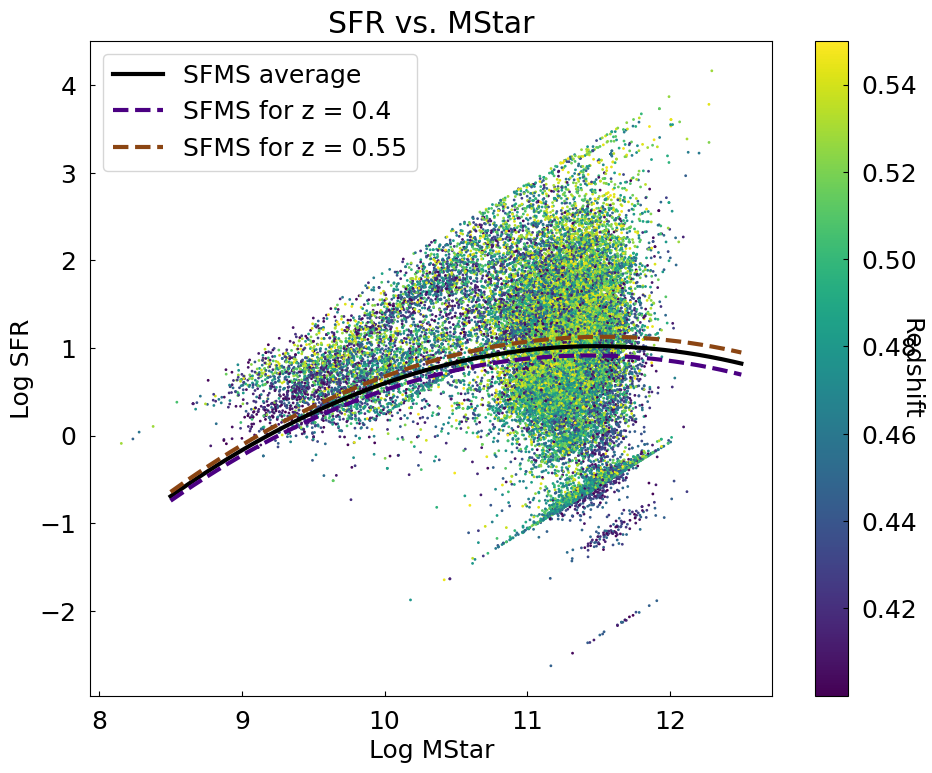

In [84]:
width = 3
cm = plt.colormaps['viridis']
sc = plt.scatter(mstar, sfr, c=redshift, vmin=np.min(redshift), vmax=np.max(redshift), s=1, cmap=cm)
plt.xlabel("Log MStar")
plt.ylabel("Log SFR")
plt.title("SFR vs. MStar")
plt.plot(x,y, color='black', label='SFMS average', linewidth=width)
plt.plot(x,y1,color='indigo', linestyle='--', label='SFMS for z = ' + str(z_low), linewidth=width)
plt.plot(x,y2, color='saddlebrown', linestyle='--', label='SFMS for z = '  + str(z_high), linewidth=width)
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Redshift', rotation = 270)
# plt.savefig('sfms_plot_range.png')
plt.show()

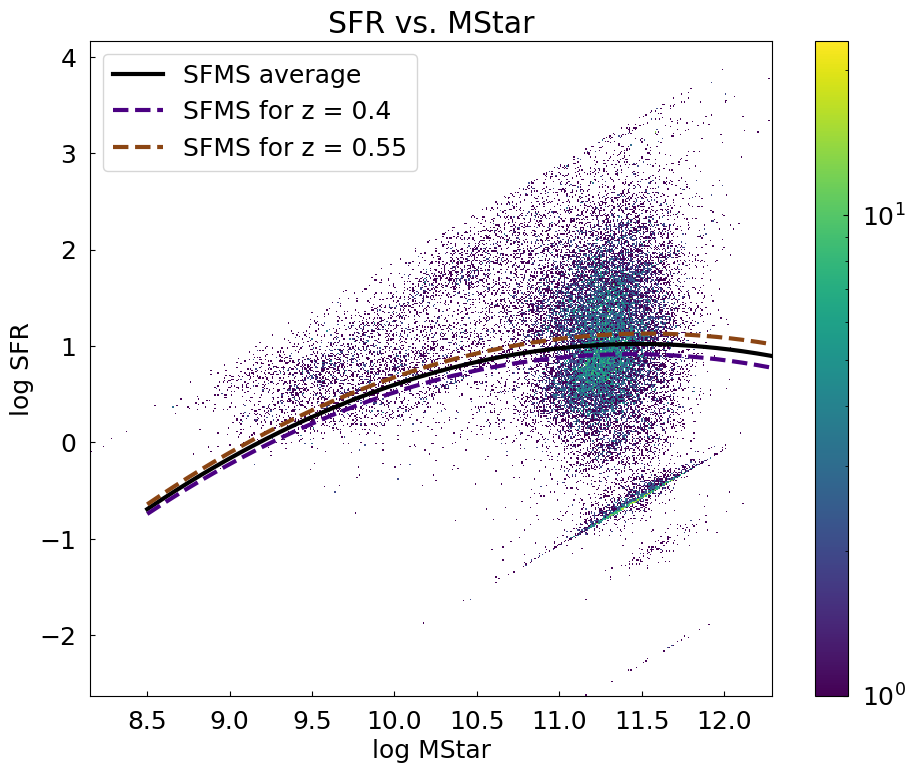

In [85]:
# density plotting

def plot_sfr_vs_mass(m, s, name):
    #Plot mass against metalicity as a 2d histogram

    plt.hist2d(m,s, bins=500, norm=LogNorm())
    plt.colorbar()
    plt.title('SFR vs. MStar')
    plt.xlabel(r'log MStar')
    plt.ylabel(r'log SFR')

    plt.plot(x,y, color='black', label='SFMS average', linewidth=width)
    plt.plot(x,y1,color='indigo', linestyle='--', label='SFMS for z = '  + str(z_low), linewidth=width)
    plt.plot(x,y2, color='saddlebrown', linestyle='--', label='SFMS for z = '  + str(z_high), linewidth=width)
    plt.legend(loc='upper left')
    
    plt.savefig(name + ".png")
    plt.show()

plot_sfr_vs_mass(mstar, sfr, "ms_vs_sfr_density_1")

#### Selecting Above Star-Forming Main Sequence:

In [86]:
# cuts on redshift and S/N again but with cut at SFMS

restrictions_sfms = np.where((data['LOGMSTAR'] > 8) & (data['Z'] > z_low) & (data['Z'] < z_high) & (data['LOGSFR_ERR'] < 0.3) & (data['LOGMSTAR_ERR'] < 0.2) & (data['LOGSFR'] > (sfms(data['LOGMSTAR'], age_low) + 0.1)) & ((data['H_ALPHA_FLUX']/data['H_ALPHA_FLUX_ERR']) > 3) & ((data['H_BETA_FLUX']/data['H_BETA_FLUX_ERR']) > 3))[0]                       

In [87]:
data_clipped_sfms = np.array(data[restrictions_sfms])

In [88]:
sfr_sfms = data_clipped_sfms['LOGSFR']
mstar_sfms = data_clipped_sfms['LOGMSTAR']
redshift_sfms = data_clipped_sfms['Z']

ra_sfms = data_clipped_sfms['RA']
dec_sfms = data_clipped_sfms['DEC']

o3hb_sfms = data_clipped_sfms['LOGO3HB']
o3_sfms = data_clipped_sfms['OIII_5007_FLUX']
hb_sfms = data_clipped_sfms['H_BETA_FLUX']
hb_err_sfms = data_clipped_sfms['H_BETA_FLUX_ERR']
ha_sfms = data_clipped_sfms['H_ALPHA_FLUX']
ha_err_sfms = data_clipped_sfms['H_ALPHA_FLUX_ERR']
hg_sfms = data_clipped_sfms['H_GAMMA_FLUX']
hg_err_sfms = data_clipped_sfms['H_GAMMA_FLUX_ERR']
av_ism_sfms = data_clipped_sfms['AV_ISM']
av_ism_err_sfms = data_clipped_sfms['AV_ISM_ERR']

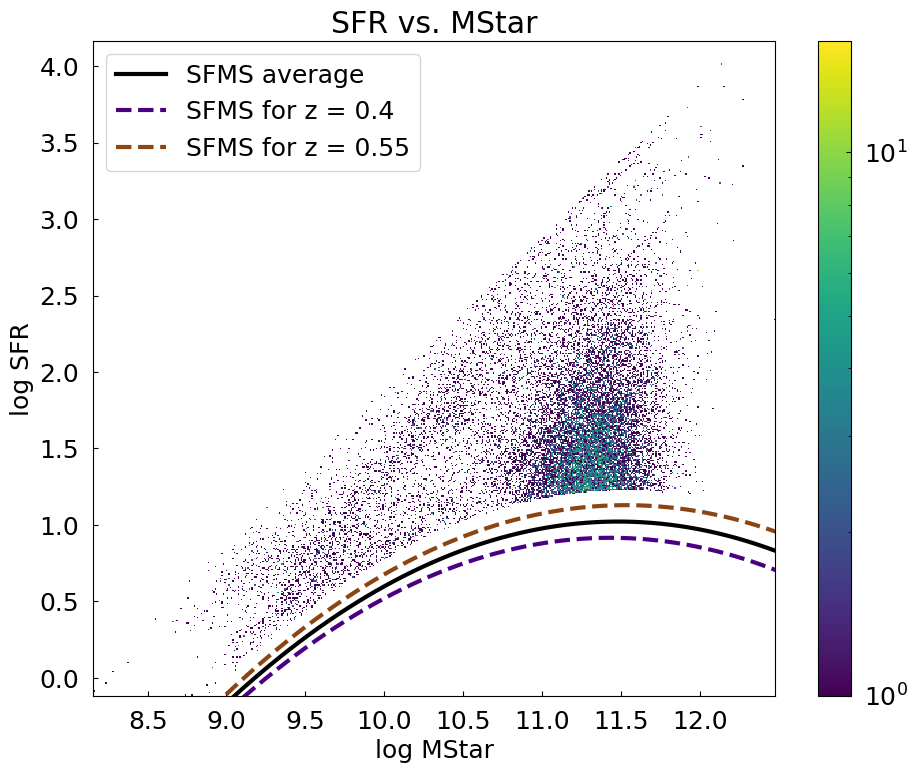

In [89]:
plot_sfr_vs_mass(mstar_sfms, sfr_sfms, "ms_vs_sfr_density_above_sfms")

## BPT AGN Indicator

In [90]:
x_data = n2ha # n2/ha value from table for each galaxy
y_data = o3hb # o3/hb value from table for each galaxy

x_min = np.min(x_data)
x_max = np.max(x_data)

In [91]:
z_avg = (0.4+0.55)/2

In [92]:
x_line = np.linspace(-2.5, 0, num=400) # create array of x values
y_line = (0.61/(x_line- (0.02 + 0.1833*z_avg))) + (1.2 + 0.03*z_avg) # indicator line

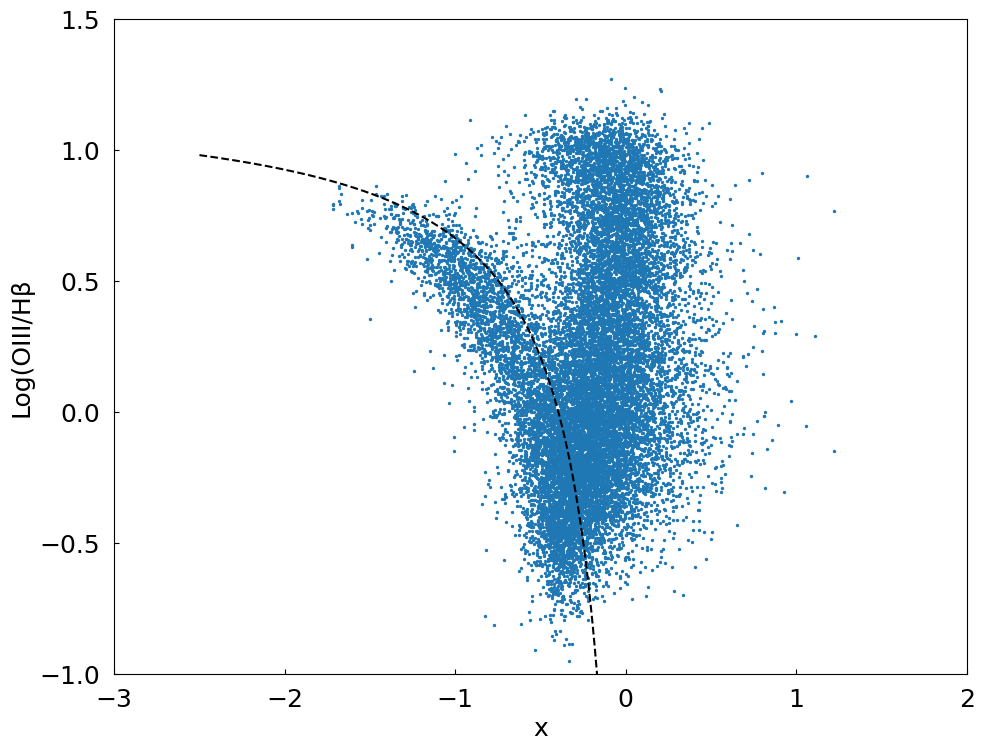

In [93]:
plt.scatter(x_data, y_data, s=2)
plt.plot(x_line, y_line, color='black', linestyle='--')
plt.xlabel("x")
plt.ylabel("Log(OIII/Hβ")
plt.ylim(-1, 1.5)
plt.xlim(-3, 2)
plt.show()

In [94]:
# define points that fall in star-forming region

sf_index = np.where((o3hb < ((0.61/(n2ha- (0.02 + 0.1833*z_avg))) + (1.2 + 0.03*z_avg))) & (o3hb > -999) & (n2ha > -999) & (n2ha < 0))

In [95]:
sf_mstar = np.array(mstar[sf_index])
sf_sfr = np.array(sfr[sf_index])
sf_redshift = np.array(redshift[sf_index])

sf_ra = np.array(ra[sf_index])
sf_dec = np.array(dec[sf_index])
sf_plate = np.array(plate[sf_index])
sf_mjd = np.array(mjd[sf_index])
sf_fiber = np.array(fiber[sf_index])

sf_o3 = np.array(o3[sf_index])
sf_hb = np.array(hb[sf_index])
sf_hb_err = np.array(hb_err[sf_index])
sf_o3hb = np.array(o3hb[sf_index])
sf_ha = np.array(ha[sf_index])
sf_ha_err = np.array(ha_err[sf_index])
sf_hg = np.array(hg[sf_index])
sf_hg_err = np.array(hg_err[sf_index])
sf_n2ha = np.array(n2ha[sf_index])

sf_av_ism = np.array(av_ism[sf_index])
sf_av_ism_err = np.array(av_ism_err[sf_index])
sf_infiber = np.array(infiber[sf_index])

sf_c_bayes = np.array(c_bayes[sf_index])
sf_c_best = np.array(c_best[sf_index])
sf_phot_data = np.array(phot_data[sf_index])
sf_phot_data_ivar = np.array(phot_data_ivar[sf_index])
sf_model_mag = np.array(model_mag[sf_index])
sf_model_mag_ivar = np.array(model_mag_ivar[sf_index])
sf_spec_mag = np.array(spec_mag[sf_index])
sf_spec_mag_ivar = np.array(spec_mag_ivar[sf_index])
sf_ebv = np.array(ebv[sf_index])

In [96]:
# define star-forming points for plot

x_sf = sf_n2ha
y_sf = sf_o3hb

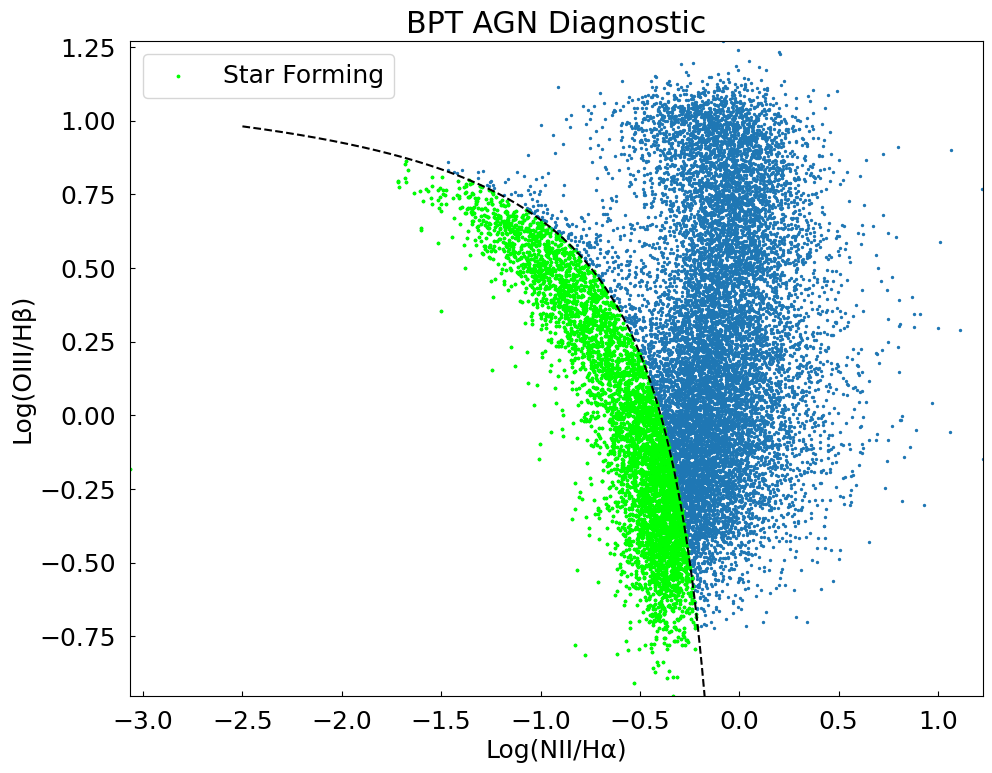

In [97]:
plt.scatter(x_data, y_data, s=2)
plt.scatter(x_sf, y_sf, s=3, color='lime', label="Star Forming")
plt.plot(x_line, y_line, color='black', linestyle='--')
plt.xlabel("Log(NII/Hα)")
plt.ylabel("Log(OIII/Hβ)")
plt.ylim(min(y_sf), max(y_data))
plt.xlim(min(x_sf), max(x_data))
plt.title("BPT AGN Diagnostic")
plt.legend(loc="upper left")
plt.show()

## Plotting S/N for Hydrogen Lines

In [98]:
hb_snr = sf_hb/sf_hb_err
ha_snr = sf_ha/sf_ha_err
hg_snr = sf_hg/sf_hg_err

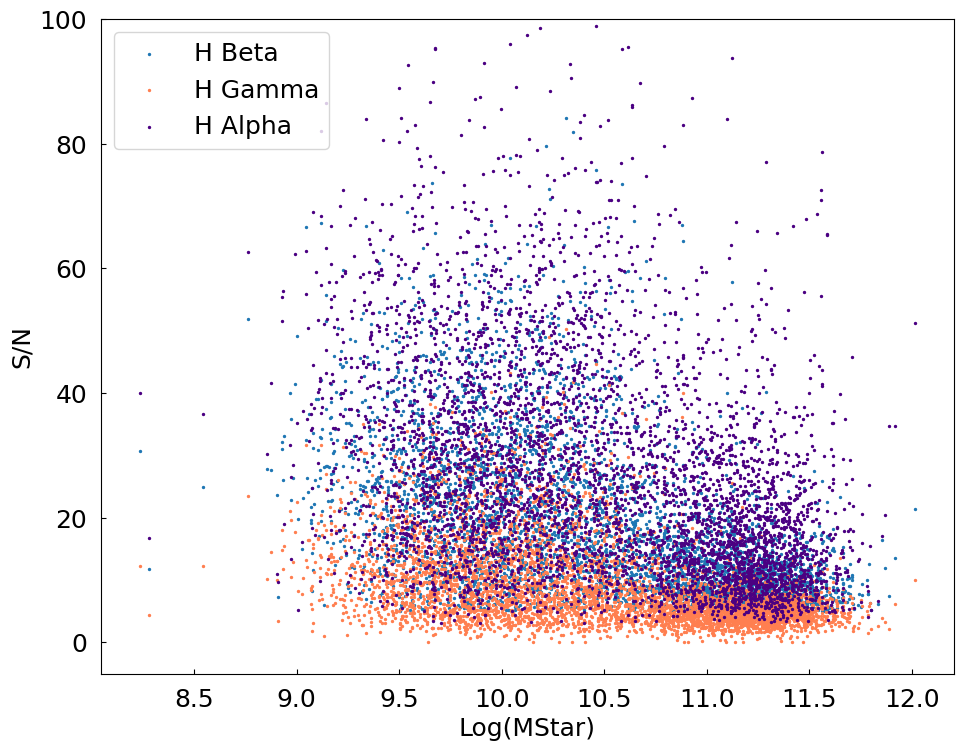

In [99]:
plt.scatter(sf_mstar, hb_snr, s=2, label="H Beta")
plt.scatter(sf_mstar, hg_snr, s=2, color='coral', label="H Gamma")
plt.scatter(sf_mstar, ha_snr, s=2, color='indigo', label="H Alpha")
plt.ylim(-5, 100)
plt.xlabel("Log(MStar)")
plt.ylabel("S/N")
plt.legend(loc="upper left")
plt.show()

## Dereddening

### E(V-B) and AV Values

In [100]:
extinction = [] # E(V-B)

def calculate_extinction(ha, hb):
    ex = 1.97*np.log10((ha/hb)/2.86)
    return ex

for i in range(len(sf_hb)):
    extinction.append(calculate_extinction(sf_ha[i], sf_hb[i]))

In [101]:
for i in range(len(extinction)):
    if extinction[i] < 0:
        extinction[i] = 0

In [102]:
av_balmer = []
rv = 3.1

for i in range(len(extinction)):
    av = extinction[i]*rv
    av_balmer.append(av)

In [103]:
AV_balmer = np.array(av_balmer) # fixing type issue

In [104]:
# making error cut

av_ism_err_cutoff = np.where(sf_av_ism_err < 0.3)

sf_av_ism_cutoff = np.array(sf_av_ism[av_ism_err_cutoff])
AV_balmer_cutoff = np.array(AV_balmer[av_ism_err_cutoff])
AV_ISM = sf_av_ism_cutoff

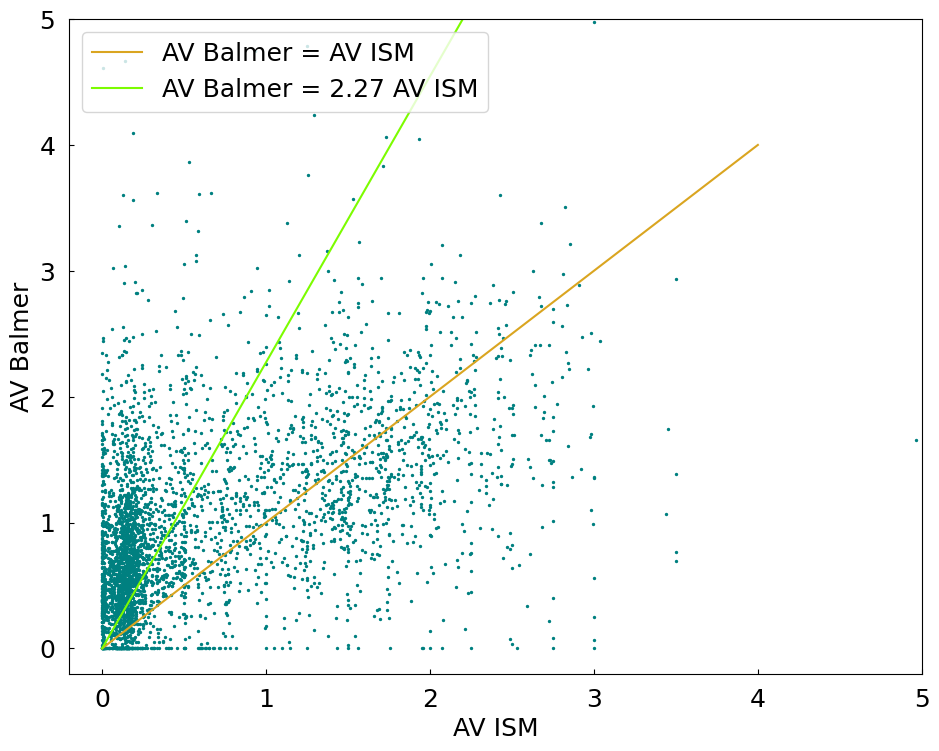

In [105]:
correlation = np.linspace(0, 4, num=300)

plt.scatter(AV_ISM, AV_balmer_cutoff, s=2, color="teal")
plt.plot(correlation, correlation, label="AV Balmer = AV ISM", color="goldenrod")
plt.plot(correlation, (1/0.44)*correlation, label='AV Balmer = 2.27 AV ISM', color="lawngreen")
plt.xlabel("AV ISM")
plt.ylabel("AV Balmer")
plt.legend(loc="upper left")
plt.ylim(-.2,5)
plt.xlim(-0.2,5)
plt.show()

### Dereddening Package

Documentation: https://dust-extinction.readthedocs.io/en/latest/

In [106]:
from dust_extinction.parameter_averages import G23

# define the model
ext = G23(Rv=3.1)

In [107]:
# wavelengths and spectrum are 1D arrays
# wavelengths between 1000 and 30000 A
ha_wavelength = 6563*u.AA # AA means angstrom!
spectrum_noext = [] # dereddened Ha!

for i in range(len(extinction)):
    wavelengths = ha_wavelength
    spectrum = sf_ha[i]* u.erg / (u.cm ** 2 * u.s)
    # unextinguish (deredden) the spectrum
    unext = spectrum/ext.extinguish(wavelengths, Ebv=extinction[i])
    spectrum_noext.append(unext)

## Calculating H-Alpha SFR

### HA Luminosity

In [108]:
ha_flux = []
for i in range(len(spectrum_noext)):
    ha_flux.append(spectrum_noext[i]*(10**(-17)))

In [109]:
lum_dist = []

for i in range(len(sf_redshift)):
    d = cosmo.luminosity_distance(sf_redshift[i])
    dcm = d.to(u.cm)
    lum_dist.append(dcm)

In [110]:
ha_lum = []

for i in range(len(lum_dist)):
    lum = 4*np.pi*(lum_dist[i]**2)*(ha_flux[i])
    ha_lum.append(lum)

### Fiber Correction

In [111]:
sf_infiber_corrected = []

for i in range(len(sf_infiber)):
    if sf_infiber[i] > 1 or sf_infiber[i] < 0:
        sf_infiber_corrected.append(1)
    elif sf_infiber[i] < 0.2:
        sf_infiber_corrected.append(0.2)
    else:
        sf_infiber_corrected.append(sf_infiber[i])

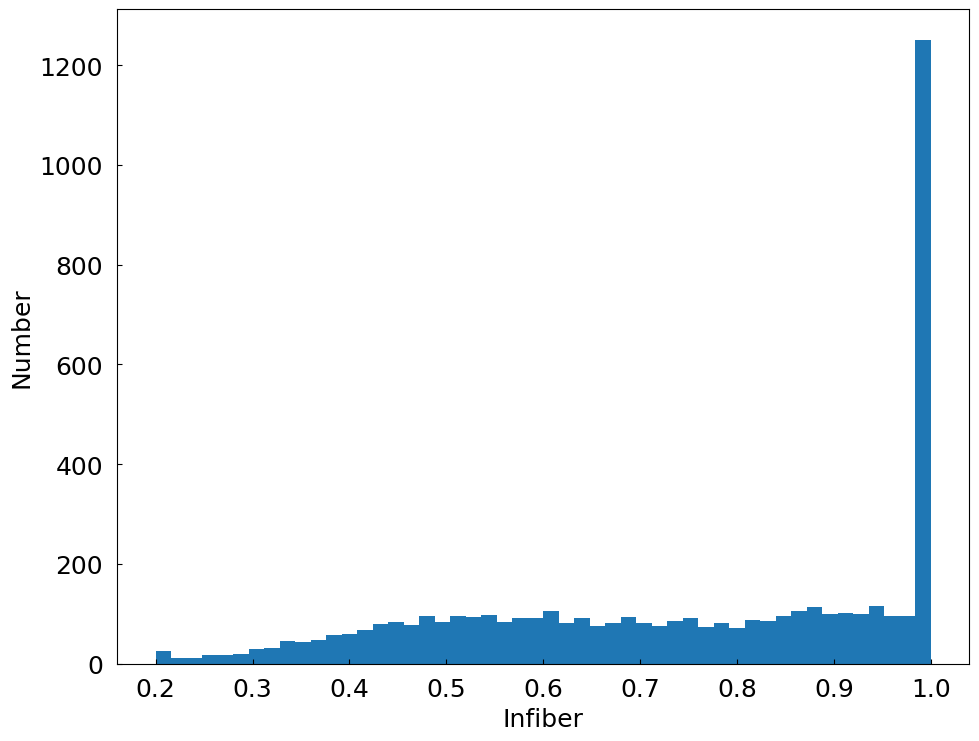

In [112]:
plt.hist(sf_infiber_corrected, bins=50)
plt.ylabel("Number")
plt.xlabel("Infiber")
plt.show()

In [113]:
ha_lum_corrected = []

for i in range(len(ha_lum)):
    c = ha_lum[i]/sf_infiber_corrected[i]
    ha_lum_corrected.append(c)

### SFR

In [114]:
ha_sfr = []

for i in range(len(ha_lum_corrected)):
    s = np.log10(ha_lum_corrected[i]/ha_lum_corrected[i].unit) - 41.27
    ha_sfr.append(s)

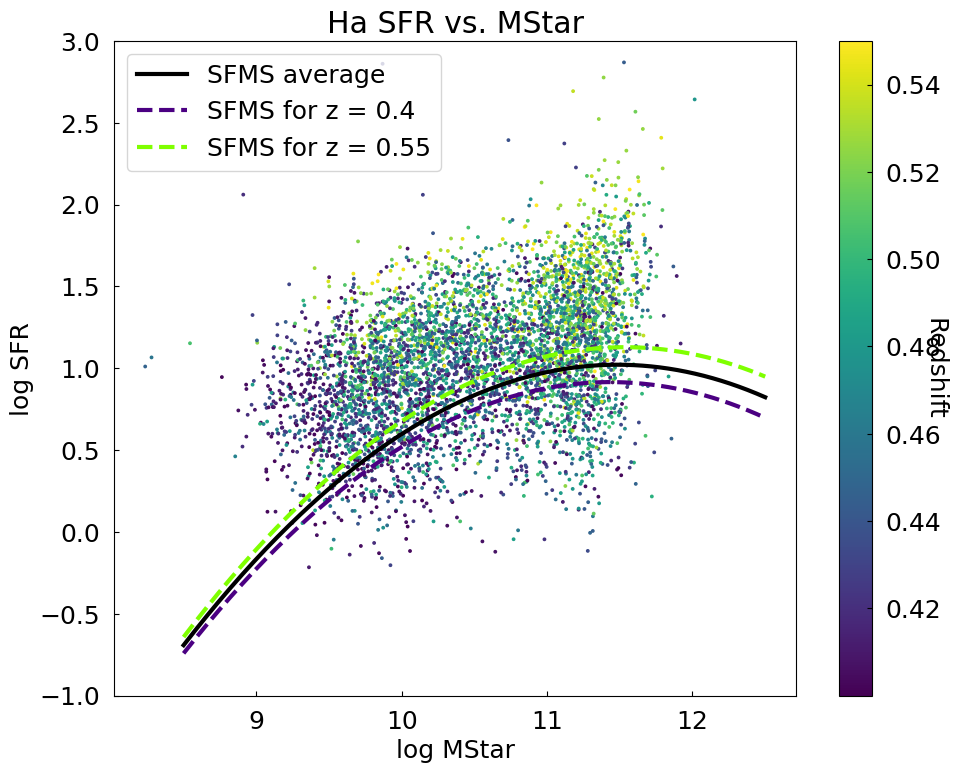

In [116]:
cm = plt.colormaps['viridis']
sc = plt.scatter(sf_mstar, ha_sfr, c=sf_redshift, vmin=np.min(sf_redshift), vmax=np.max(sf_redshift), s=3, cmap=cm)
plt.title('Ha SFR vs. MStar')
plt.xlabel(r'log MStar')
plt.ylabel(r'log SFR')

plt.plot(x,y, color='black', label='SFMS average', linewidth=3)
plt.plot(x,y1,color='indigo', linestyle='--', label='SFMS for z = ' + str(z_low), linewidth=3)
plt.plot(x,y2, color='chartreuse', linestyle='--', label='SFMS for z = ' + str(z_high), linewidth=3)
plt.legend(loc='upper left')
cbar = plt.colorbar(sc)
cbar.set_label('Redshift', rotation = 270)
plt.ylim(-1,3)
plt.show()

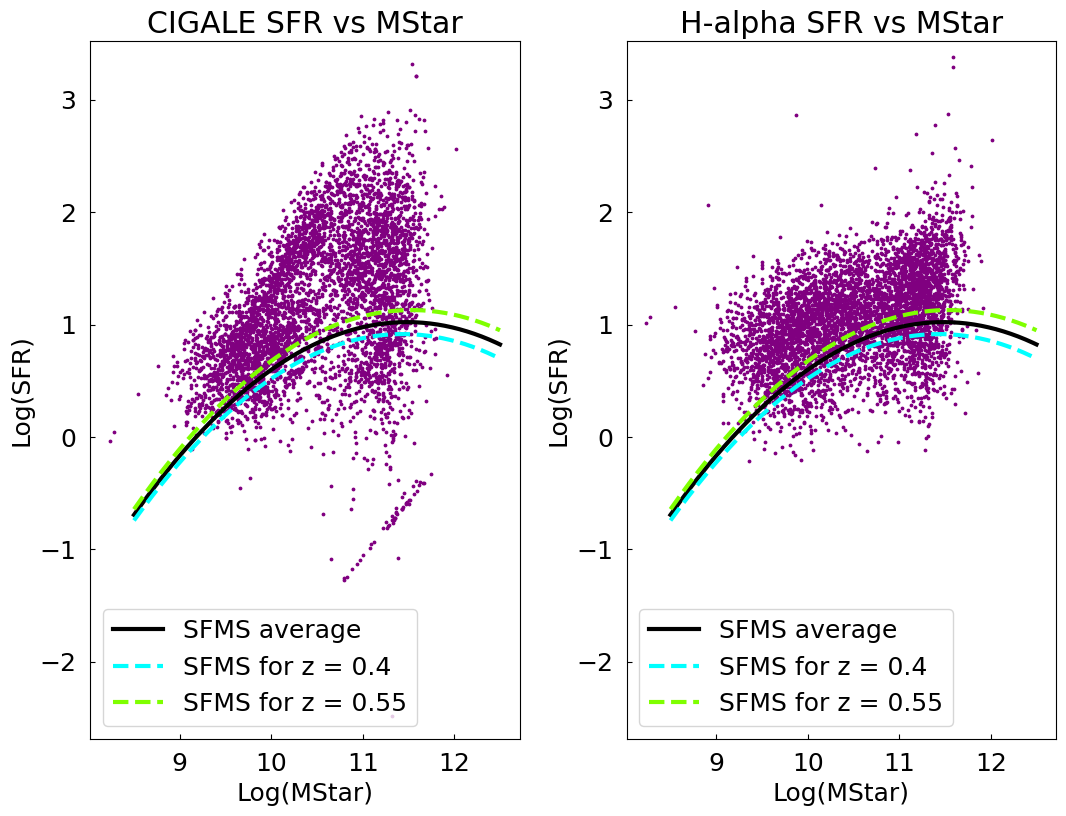

In [117]:
# CIGALE and Ha SFR side-by-side

plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.scatter(sf_mstar, sf_sfr, s=3, color='purple')
plt.title('CIGALE SFR vs MStar')
plt.xlabel('Log(MStar)')
plt.ylabel('Log(SFR)')
plt.ylim(min(sf_sfr)-0.2, max(sf_sfr)+0.2)
plt.plot(x,y, color='black', label='SFMS average', linewidth=3)
plt.plot(x,y1,color='cyan', linestyle='--', label='SFMS for z = ' + str(z_low), linewidth=3)
plt.plot(x,y2, color='chartreuse', linestyle='--', label='SFMS for z = ' + str(z_high), linewidth=3)
plt.legend(loc='lower left')

# row 1, column 2, count 2
plt.subplot(1, 2, 2)

plt.scatter(sf_mstar, ha_sfr, s=3, color='purple')
plt.title('H-alpha SFR vs MStar')
plt.xlabel('Log(MStar)')
plt.ylabel('Log(SFR)')
plt.ylim(min(sf_sfr)-0.2, max(sf_sfr)+0.2)
plt.plot(x,y, color='black', label='SFMS average', linewidth=3)
plt.plot(x,y1,color='cyan', linestyle='--', label='SFMS for z = 0.4', linewidth=3)
plt.plot(x,y2, color='chartreuse', linestyle='--', label='SFMS for z = 0.55', linewidth=3)
plt.legend(loc='lower left')

# space between the plots
plt.tight_layout()

# show plot
plt.show()

## Other

#### Printing RA and DEC List

In [118]:
sfr_cut = 2.1 # set selection criteria. here it's sfr above 2.1
sfr_index = np.where((sfr > sfr_cut))
coords = np.dstack((np.array(ra[sfr_index]), np.array(dec[sfr_index])))

#for i in range(385):
#    print(str(coords[0:1, i]).replace("[", "").replace("]", "").replace(",", "") ) # removing these characters lets you copy and paste into the sdss image tool

#### Writing out clipped fits file

In [121]:
t = Table([sf_mstar, sf_sfr, sf_redshift, sf_ra, sf_dec, sf_av_ism, sf_av_ism_err, sf_infiber, sf_ha, sf_ha_err, sf_hb, sf_hb_err, ha_sfr, av_balmer, sf_c_bayes, sf_c_best, sf_phot_data, sf_phot_data_ivar, sf_model_mag, sf_model_mag_ivar, sf_spec_mag, sf_spec_mag_ivar, sf_ebv, sf_plate, sf_mjd, sf_fiber], names=('LOGMSTAR', 'LOGSFR', 'Z', 'RA', 'DEC', 'AV_ISM', 'AV_ISM_ERR', 'INFIBER', 'H_ALPHA', 'H_ALPHA_ERR', 'H_BETA', 'H_BETA_ERR', 'SFR_H_ALPHA', 'AV_BALMER', 'CIGALE_GRIZW1W2_BAYES', 'CIGALE_GRIZW1W2_BEST', 'DATA_GRIZW1W2', 'DATA_GRIZW1W2_IVAR', 'SDSS_MODELFLUX', 'SDSS_MODELFLUX_IVAR', 'SDSS_SPECTROFLUX', 'SDSS_SPECTROFLUX_IVAR', 'EBV_MW', 'PLATE', 'MJD', 'FIBER'))

t.write('eboss_clipped_bpt_1.fits', format='fits', overwrite='True')

#### Redshift histogram

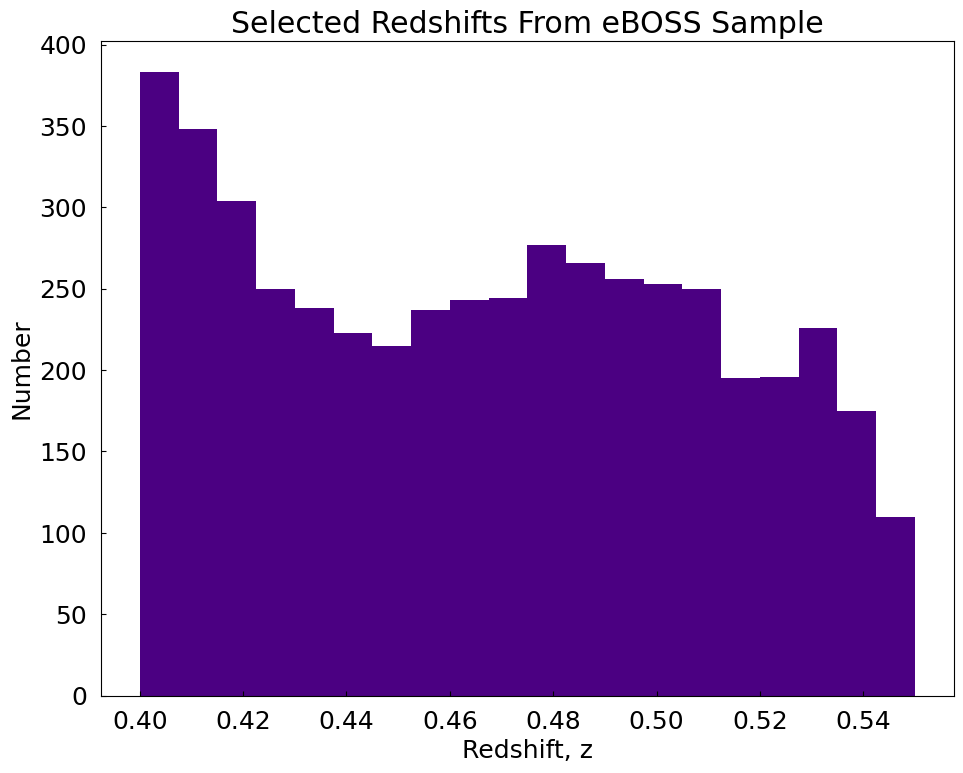

In [122]:
plt.hist(sf_redshift, bins=20, color='indigo')
plt.xlabel("Redshift, z")
plt.ylabel("Number")
plt.title("Selected Redshifts From eBOSS Sample")
plt.show()

#### Writing out WGet list

In [123]:
new_fiber = [] # fiber format needs 4 digits

for i in range(len(sf_fiber)):
    if sf_fiber[i] < 10:
        new_fiber.append("000" + str(sf_fiber[i]))
    elif sf_fiber[i] < 100:
        new_fiber.append("00" + str(sf_fiber[i]))
    else:
        new_fiber.append("0" + str(sf_fiber[i]))

In [124]:
f = open("wget_list_1.txt", "w")
for i in range(len(sf_sfr)):
    f.write("https://data.sdss.org/sas/dr17/eboss/spectro/redux/v5_13_2/spectra/lite/" + str(plate[i]) + "/spec-" + str(plate[i]) + "-" + str(mjd[i]) + "-" + new_fiber[i] + ".fits" + "\n")
f.close()

#### Command to put in terminal:
wget -nv -r -nH --cut-dirs=9 -i wget_list_1.txt -P (insert file location to save to) -B https://data.sdss.org/sas/dr17/eboss/spectro/redux/v5_13_2/spectra/lite/

## Plotting Spectra

After getting spectrum files with the WGet, you'll want to have a text file that lists those file names, as well as a FITS file with plate, MJD, fiber, CIGALE SFR, Ha SFR, E(B-V), and photometry data for plotting over the spectra. I did this using topcat to match RA and DEC of the spectra I was plotting with the corresponding entries in the full eBOSS file.

In [125]:
data_spec = load_fits('new-sample-data')

In [126]:
#data_spec.columns

In [127]:
plate_spec = data_spec['PLATE']
mjd_spec = data_spec['MJD']
fiber_spec = data_spec['FIBER']
ra_spec = data_spec['RA_1']
dec_spec = data_spec['DEC_1']

cigale_sfr = data_spec['LOGSFR']
halpha_sfr = data_spec['SFR_H_ALPHA']


c_bayes = data_spec['CIGALE_GRIZW1W2_BAYES']*u.mJy
c_best = data_spec['CIGALE_GRIZW1W2_BEST']*u.mJy
phot_data = data_spec['DATA_GRIZW1W2']*u.mJy
phot_data_ivar = data_spec['DATA_GRIZW1W2_IVAR']
model_mag = data_spec['SDSS_MODELFLUX']
model_mag_ivar = data_spec['SDSS_MODELFLUX_IVAR']
spec_mag = data_spec['SDSS_SPECTROFLUX']
spec_mag_ivar = data_spec['SDSS_SPECTROFLUX_IVAR']
ebv_mw = data_spec['EBV_MW']

### Spectrum Files

In [128]:
files_list = []

fl = open("wget-highsf/filenames.txt", "r") # insert name of text file containing list of spectra files from wget
for file in fl:
    filename = "/home/lauren/Desktop/sfms/wget-highsf/" + file
    filename2 = filename.replace("\n", "")
    files_list.append(filename2)
fl.close()

In [129]:
spec_data = []

for file in files_list:
    with fits.open(file) as f:  
        spec = f[1].data
        spec_data.append(spec)

In [130]:
spectra = []

for i in range(len(spec_data)):
    lamb = 10**spec_data[i]['loglam'] * u.AA 
    flux = spec_data[i]['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux)
    spectra.append(spec)

### Dereddening and Smoothing

In [131]:
from dust_extinction.parameter_averages import G23

# define the model
ext = G23(Rv=3.1)

In [132]:
dered_spec = []

for i in range(len(spectra)):
    noext = spectra[i].flux/ext.extinguish(spectra[i].spectral_axis, Ebv=ebv_mw[i])
    noext_spec = Spectrum1D(spectral_axis=spectra[i].spectral_axis, flux=noext)
    dered_spec.append(noext_spec)

In [133]:
sm_spectra = []

for i in range(len(dered_spec)):
    sm = specutils.manipulation.median_smooth(dered_spec[i], 5)
    sm_spectra.append(sm)

### Plotting

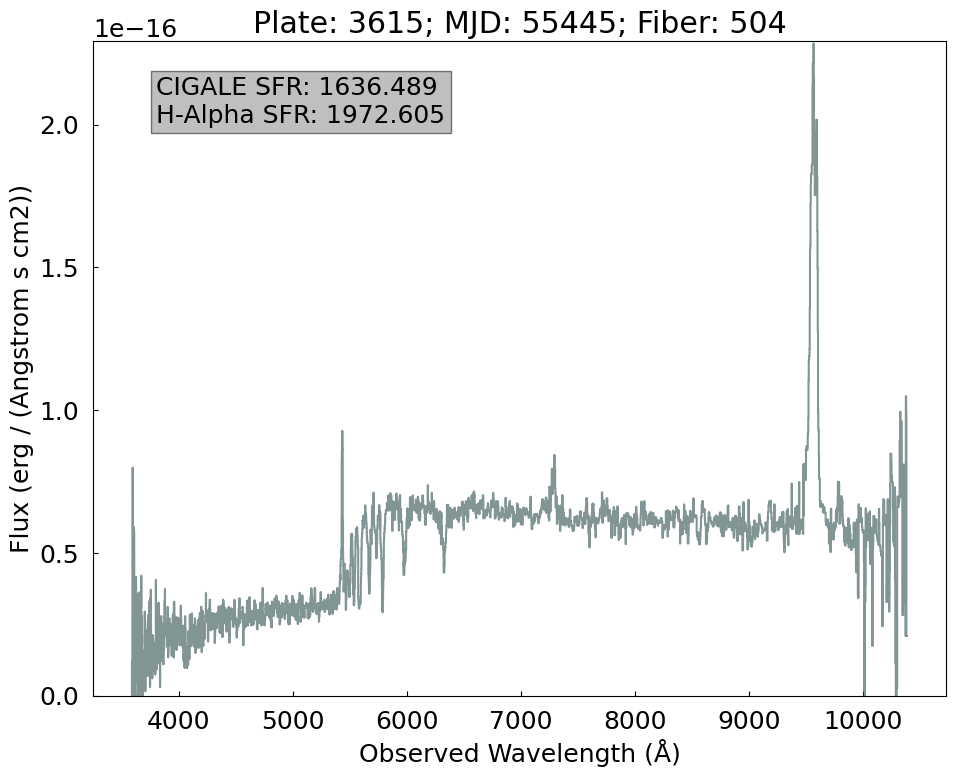

In [134]:
for i in range(1): # change range to len(sm_spectra)
    f, ax = plt.subplots()  
    ax.step(spectra[i].spectral_axis, sm_spectra[i].flux, alpha=0.6, color='darkslategray')
    plt.ylim(0, 4*statistics.median(sm_spectra[i].flux))
    
    plt.text(3800*u.AA, 3.5*statistics.median(sm_spectra[i].flux), "CIGALE SFR: " + str(round(10**cigale_sfr[i], 3)) + "\n" + "H-Alpha SFR: " + str(round(10**halpha_sfr[i], 3)), bbox = dict(facecolor = 'gray', alpha = 0.5))
    
    plt.title("Plate: " + str(plate_spec[i]) + "; MJD: " + str(mjd_spec[i]) + "; Fiber: " + str(fiber_spec[i]))
    plt.xlabel("Observed Wavelength (Å)")
    plt.ylabel("Flux (" + str(spectra[3].flux.unit) + ")")
    plt.savefig("spectrum_w_photometry_" + str(i) + ".png")
    plt.show()

### Photometry Conversions

In [135]:
c_bayes_hz = c_bayes.to(u.erg/u.s/u.cm**2/u.Hz)
c_best_hz = c_best.to(u.erg/u.s/u.cm**2/u.Hz)
phot_data_hz = phot_data.to(u.erg/u.s/u.cm**2/u.Hz)

model_mag_mjy = model_mag*3.631*(10**(-3))*u.mJy
model_mag_hz = model_mag_mjy.to(u.erg/u.s/u.cm**2/u.Hz)

spec_mag_mjy = spec_mag*3.631*(10**(-3))*u.mJy
spec_mag_hz = spec_mag_mjy.to(u.erg/u.s/u.cm**2/u.Hz)

#### Filter Centers

DECam filters: https://noirlab.edu/science/programs/ctio/filters/Dark-Energy-Camera

WISE filters: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

SDSS filters: https://skyserver.sdss.org/dr1/en/proj/advanced/color/sdssfilters.asp

In [136]:
# finding frequency for centers
# first DECam filters; SDSS filters later

g_center = 4730*u.AA
speed = 3.0*10**8*u.m/u.s

g_freq = speed/g_center.to(u.m)
g_freq = g_freq.to(u.Hz)

In [137]:
r_center = 6420*u.AA

r_freq = speed/r_center.to(u.m)
r_freq = r_freq.to(u.Hz)

In [138]:
i_center = 7840*u.AA

i_freq = speed/i_center.to(u.m)
i_freq = i_freq.to(u.Hz)

In [139]:
z_center = 9260*u.AA

z_freq = speed/z_center.to(u.m)
z_freq = z_freq.to(u.Hz)

In [140]:
w1_center = 3.4*u.um

w1_freq = speed/w1_center.to(u.m)
w1_freq = w1_freq.to(u.Hz)

In [141]:
w2_center = 4.6*u.um

w2_freq = speed/w2_center.to(u.m)
w2_freq = w2_freq.to(u.Hz)

In [142]:
w3_center = 12*u.um

w3_freq = speed/w3_center.to(u.m)
w3_freq = w3_freq.to(u.Hz)

In [143]:
w4_center = 22*u.um

w4_freq = speed/w4_center.to(u.m)
w4_freq = w4_freq.to(u.Hz)

In [144]:
sloan_u_center = 3543*u.AA

sloan_u_freq = speed/sloan_u_center.to(u.m)
sloan_u_freq = sloan_u_freq.to(u.Hz)

In [145]:
sloan_g_center = 4770*u.AA

sloan_g_freq = speed/sloan_g_center.to(u.m)
sloan_g_freq = z_freq.to(u.Hz)

In [146]:
sloan_r_center = 6231*u.AA

sloan_r_freq = speed/sloan_r_center.to(u.m)
sloan_r_freq = sloan_r_freq.to(u.Hz)

In [147]:
sloan_i_center = 7625*u.AA

sloan_i_freq = speed/sloan_i_center.to(u.m)
sloan_i_freq = sloan_i_freq.to(u.Hz)

In [148]:
sloan_z_center = 9134*u.AA

sloan_z_freq = speed/sloan_z_center.to(u.m)
sloan_z_freq = sloan_z_freq.to(u.Hz)

#### Conversions

In [149]:
c_bayes_units = []

for i in range(len(c_bayes_hz)):
    values = [c_bayes_hz[i][0]*g_freq/g_center, 
              c_bayes_hz[i][1]*r_freq/r_center, 
              c_bayes_hz[i][2]*i_freq/i_center,
              c_bayes_hz[i][3]*z_freq/z_center,
              c_bayes_hz[i][4]*w1_freq/w1_center.to(u.AA), 
              c_bayes_hz[i][5]*w2_freq/w2_center.to(u.AA)]
    c_bayes_units.append(values)

In [150]:
c_best_units = []

for i in range(len(c_bayes_hz)):
    values = [c_best_hz[i][0]*g_freq/g_center, 
              c_best_hz[i][1]*r_freq/r_center, 
              c_best_hz[i][2]*i_freq/i_center, 
              c_best_hz[i][3]*z_freq/z_center, 
              c_best_hz[i][4]*w1_freq/w1_center.to(u.AA), 
              c_best_hz[i][5]*w2_freq/w2_center.to(u.AA)]
    c_best_units.append(values)

In [151]:
phot_data_units = []

for i in range(len(c_bayes_hz)):
    values = [phot_data_hz[i][0]*g_freq/g_center, 
              phot_data_hz[i][1]*r_freq/r_center, 
              phot_data_hz[i][2]*i_freq/i_center, 
              phot_data_hz[i][3]*z_freq/z_center, 
              phot_data_hz[i][4]*w1_freq/w1_center.to(u.AA), 
              phot_data_hz[i][5]*w2_freq/w2_center.to(u.AA)]
    phot_data_units.append(values)

In [152]:
model_mag_units = []

for i in range(len(model_mag_hz)):
    values = [model_mag_hz[i][0]*sloan_u_freq/sloan_u_center,
              model_mag_hz[i][1]*sloan_g_freq/sloan_g_center, 
              model_mag_hz[i][2]*sloan_r_freq/sloan_r_center, 
              model_mag_hz[i][3]*sloan_i_freq/sloan_i_center, 
              model_mag_hz[i][4]*sloan_z_freq/sloan_z_center]
    model_mag_units.append(values)

In [153]:
spec_mag_units = []

for i in range(len(c_bayes_hz)):
    values = [spec_mag_hz[i][0]*sloan_u_freq/sloan_u_center,
              spec_mag_hz[i][1]*sloan_g_freq/sloan_g_center, 
              spec_mag_hz[i][2]*sloan_r_freq/sloan_r_center, 
              spec_mag_hz[i][3]*sloan_i_freq/sloan_i_center, 
              spec_mag_hz[i][4]*sloan_z_freq/sloan_z_center]
    spec_mag_units.append(values)

In [154]:
bayes = c_bayes_units
best = c_best_units
phot = phot_data_units
specmags = spec_mag_units
modelmags = model_mag_units

### Plotting Spectra With Photometry

In [155]:
gband = np.linspace(3980, 5480, num=6000)*u.AA
rband = np.linspace(5680, 7160, num=6000)*u.AA
iband = np.linspace(7100, 8570, num=6000)*u.AA
zband = np.linspace(8500, 10020, num=6000)*u.AA

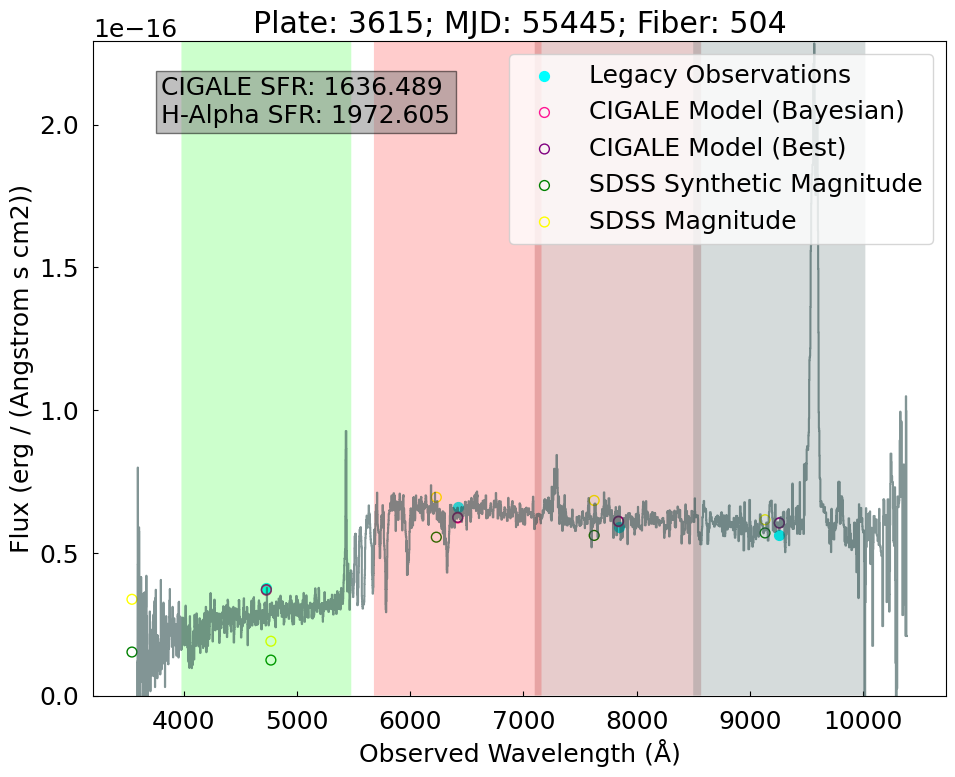

In [156]:
for i in range(1): # change range to len(spectra)
    f, ax = plt.subplots()  
    ax.step(spectra[i].spectral_axis, sm_spectra[i].flux, alpha=0.6, color='darkslategray')
    plt.scatter([g_center, r_center, i_center, z_center], phot[i][0:4], s=50, color='cyan', label='Legacy Observations')
    plt.scatter([g_center, r_center, i_center, z_center], bayes[i][0:4], s=50, label='CIGALE Model (Bayesian)', facecolors='none', edgecolors='deeppink')
    plt.scatter([g_center, r_center, i_center, z_center], best[i][0:4], s=50,  label='CIGALE Model (Best)', facecolors='none', edgecolors='purple')
    plt.scatter([sloan_u_center, sloan_g_center, sloan_r_center, sloan_i_center, sloan_z_center], specmags[i][0:5], s=50,  label='SDSS Synthetic Magnitude', facecolors='none', edgecolors='green')
    plt.scatter([sloan_u_center, sloan_g_center, sloan_r_center, sloan_i_center, sloan_z_center], modelmags[i][0:5], s=50,  label='SDSS Magnitude', facecolors='none', edgecolors='yellow')
    plt.ylim(0, 4*statistics.median(sm_spectra[i].flux))
    
    plt.text(3800*u.AA, 3.5*statistics.median(sm_spectra[i].flux), "CIGALE SFR: " + str(round(10**cigale_sfr[i], 3)) + "\n" + "H-Alpha SFR: " + str(round(10**halpha_sfr[i], 3)), bbox = dict(facecolor = 'gray', alpha = 0.5))

    ax.fill_between(gband, 4*statistics.median(sm_spectra[i].flux), where=gband>0, facecolor='lime', alpha=.2)
    ax.fill_between(rband, 4*statistics.median(sm_spectra[i].flux), where=rband>0, facecolor='red', alpha=.2)
    ax.fill_between(iband, 4*statistics.median(sm_spectra[i].flux), where=iband>0, facecolor='darkred', alpha=.2)
    ax.fill_between(zband, 4*statistics.median(sm_spectra[i].flux), where=zband>0, facecolor='darkslategray', alpha=.2)
    
    plt.title("Plate: " + str(plate_spec[i]) + "; MJD: " + str(mjd_spec[i]) + "; Fiber: " + str(fiber_spec[i]))
    plt.xlabel("Observed Wavelength (Å)")
    plt.ylabel("Flux (" + str(phot[i][3].unit) + ")")
    plt.legend(loc='upper right')
    plt.savefig("spectrum_w_photometry_" + str(i) + ".png")
    plt.show()

## Coadding Spectra

In [158]:
# interpolate each spectrum on new axis
# replace "sm_spectra" with the array of spectra you want to coadd

new_axis = np.linspace(min(sm_spectra[0].spectral_axis), max(sm_spectra[0].spectral_axis), 10000)
interpol_spectra = []

for i in range(len(sm_spectra)):
    x = sm_spectra[i].spectral_axis
    y = sm_spectra[i].flux
    ynew = np.interp(new_axis, x, y)
    interpol_spectra.append(ynew)

In [159]:
def sum1(arr):
    if len(arr) == 1:
        return arr[0]
    else:
        return arr[0] + sum1(arr[1:])

In [160]:
coadded_intermediate = sum1(interpol_spectra)

coadded = coadded_intermediate/len(interpol_spectra)

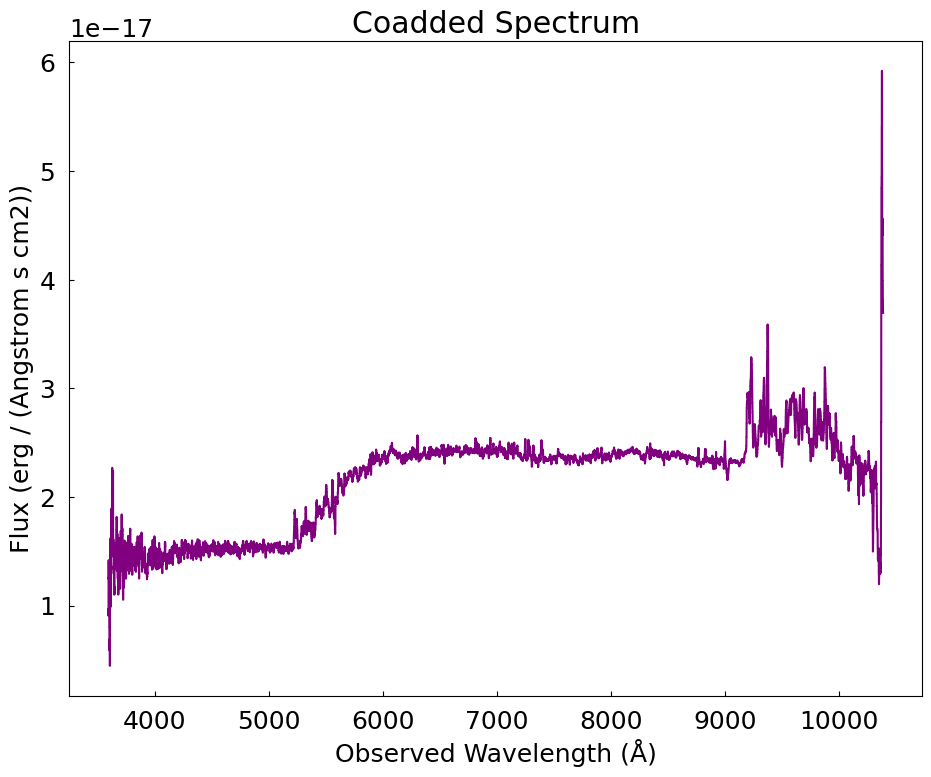

In [162]:
f, ax = plt.subplots() 
ax.step(new_axis, coadded, color='purple')

plt.title("Coadded Spectrum")
plt.xlabel("Observed Wavelength (Å)")
plt.ylabel("Flux (" + str(sm_spectra[0].flux.unit) + ")")
#plt.legend(loc='upper right')
plt.savefig("coadded_1.png")
plt.show()

## WISE Light Curves

Documentation: https://github.com/HC-Hwang/wise_light_curves?tab=readme-ov-file

In [187]:
# replace ra and dec and the path where you want to save the data

download_single_data(name='wise-galaxy', ra=ra_spec[0], dec=dec_spec[0], root_path='/home/lauren/Desktop/sfms/wise-light-curve/', radius=2.)

In [188]:
# replace file names/locations

allwise = ascii.read('wise-light-curve/wise-galaxy_allwise.ipac', format='ipac')
neowise = ascii.read('wise-light-curve/wise-galaxy_neowise.ipac', format='ipac')

In [189]:
allwise, neowise = only_good_data_v1(allwise, neowise)

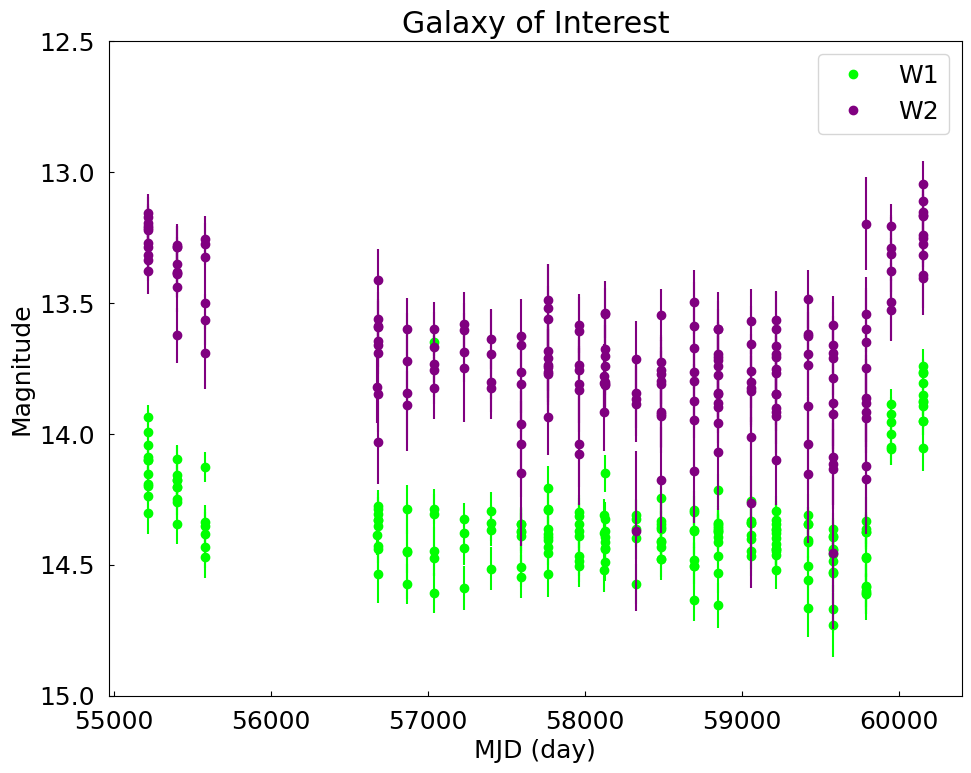

In [193]:
plt.figure()

plt.plot(allwise['mjd'], allwise['w1mpro_ep'], 'o', label='W1', color='lime')
plt.plot(neowise['mjd'], neowise['w1mpro'], 'o', color='lime')
plt.errorbar(allwise['mjd'], allwise['w1mpro_ep'], yerr = allwise['w1sigmpro_ep'], color='lime', linestyle='')
plt.errorbar(neowise['mjd'], neowise['w1mpro'], yerr = neowise['w1sigmpro'], color='lime', linestyle='')

plt.plot(allwise['mjd'], allwise['w2mpro_ep'], 'o', label='W2', color='purple')
plt.plot(neowise['mjd'], neowise['w2mpro'], 'o', color='purple')
plt.errorbar(allwise['mjd'], allwise['w2mpro_ep'], yerr = allwise['w2sigmpro_ep'], color='purple', linestyle='')
plt.errorbar(neowise['mjd'], neowise['w2mpro'], yerr = neowise['w2sigmpro'], color='purple', linestyle='')

plt.gca().invert_yaxis()
plt.legend()
plt.title('Galaxy of Interest')
plt.xlabel('MJD (day)')
plt.ylabel('Magnitude')
plt.ylim(15, 12.5)
plt.show()